# Programming Assignment 3: Autoencoders

## PACKAGE IMPLEMENTATION

Download the necessary libraries

In [1]:
# Import the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # used for one hot encoding

## DATA LOADING AND DATA PREPARATION

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Get the training and testing datasets
# First need to transform the images into a suitable form (normalization) and convert them to a Tensor
# DataLoader class
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

dataloaders = {}
# First I import the "full" dataset without dividing it into batches. I'll do it during the training of the model
batch_size = 256
dataloaders['train'] = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(testset, len(testset), shuffle=False)

# train_features, train_labels = next(iter(dataloaders['train']))
test_features, test_labels = next(iter(dataloaders['test']))
test_features = test_features.to(device)
test_labels = test_labels.to(device)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:10<00:00, 923428.14it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 134829.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:06<00:00, 247060.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4930261.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## CHECKS

In [4]:
ds_type = 'train'
for images, labels in dataloaders[ds_type]:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])


##  1 Comparing PCA and Autoencoders

Do PCA on it and take only the first 30 eigenvalues with their corresponding eigenvectors.

In [5]:
print(testset.data.shape)

torch.Size([10000, 28, 28])


In [7]:
# torch.pca_lowrank(A, q=None, center=True, niter=2)

def PCA(input_data,k):
  """
  Perform Principal Component Analysis

  :param:
  input_data: data matrix with n samples and l features (DataSet)
  k: how many principal components to be taken

  :return:
  V: shape(784,k) top k eigen vectors in columns
  centered_ip_data= shape(num_datapts,784): centered ip data (used for reconstruction from principal components)
  """

  # First I need to flatten the data
  # For every n flat the image
  input_flatten = input_data.data.reshape(input_data.data.shape[0], input_data.data.shape[1]*input_data.data.shape[2])
  X = input_flatten.float()
  # First we normalize the data
  # Center the data: mean = 0
  input_mean = torch.mean(X, 0)
  X_centered = X-input_mean
  # Covariance of centered data = XT*X
  cov_matrix = torch.matmul(X_centered.T, X_centered)

  # Get the eigen values and eigen vectors
  eigen_values, eigen_vectors = torch.linalg.eigh(cov_matrix)
  # Then we sort them to get the top k
  eigen_values_descending, indices = torch.sort(eigen_values,descending=True)
  top_k_eigen_values, top_k_indices = eigen_values_descending[:k], indices[:k]
  V = eigen_vectors[:, top_k_indices] # then Z = X_centered*V

  return V

In [8]:
# PCA on it and take only the first 30 eigenvalues with their corresponding eigenvectors
pc = PCA(trainset, 30)
print(pc.shape) # shape is correct

torch.Size([784, 30])


Now, project the data onto these eigenvectors and reconstruct them from 30 dimensional representation.

X_rec = ZV<sup>T</sup> = XVV<sup>T</sup>

In [9]:
def reconstruct_data(principal_components, X):
  """
  Reconstruct the datapoints from the principal components
  :param:
  principal_components: shape(784,k), top k eigen vectors in columns
  X: shape(num_datapoints,784), centered ip data (used for reconstruction from principal components)

  :return:
  projected_data = (torch matrix) = of shape num_datapts , top_k_ev
  """
  projection_matrix = torch.matmul(principal_components,principal_components.T)
  projected_data = torch.matmul(X,projection_matrix)
  return projected_data

In [10]:
# I first want to find a "part" of the dataset with all unique classes (same in assignment 2)
# Then I'll try to reconstruct these values using PCA
for images,labels in dataloaders['test']:
  print(torch.unique(labels[9705:9715]))
for k in range(9705,9715):
  print(k, labels[k])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
9705 tensor(1)
9706 tensor(2)
9707 tensor(3)
9708 tensor(4)
9709 tensor(5)
9710 tensor(6)
9711 tensor(7)
9712 tensor(8)
9713 tensor(9)
9714 tensor(0)


In [11]:
# Need to flatten outside so I can get the values I want
test_dataset = testset.data.reshape(testset.data.shape[0], testset.data.shape[1]*testset.data.shape[2])
test_dataset_unique = test_dataset[np.arange(9705,9715), :]
reconstructed_test_data = reconstruct_data(pc, test_dataset_unique.float())

print(reconstructed_test_data.shape)

torch.Size([10, 784])


Next, train an AE with the following specifications:

<b>Encoder:</b> fc(512)-fc(256)-fc(128)-fc(30) </br>
<b>Decoder:</b> fc(128)-fc(256)-fc(784) </br>
Use ReLU as the activation function. Compare the Reconstruction Accuracy with PCA and comment.

In [12]:
class StdAE1(nn.Module):
  def __init__(self):
    super(StdAE1, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(784,512),
      nn.ReLU(),
      nn.Linear(512,256),
      nn.ReLU(),
      nn.Linear(256,128),
      nn.ReLU(),
      nn.Linear(128,30),
      nn.ReLU())
    self.decoder =nn.Sequential(
      nn.Linear(30,128),
      nn.ReLU(),
      nn.Linear(128,256),
      nn.ReLU(),
      nn.Linear(256,784),
      nn.ReLU())

  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    x=self.decoder(x)
    return x,encoded_output

In [13]:
learning_rate = 3e-4 # karpathy's constant
epochs = 10

model1 = StdAE1()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate)

In [14]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs=5, device='cpu'):
    """
    Train the model given the data. For num_epochs of time the model is trained, which
    means that, based on the backward propagation, the weights (params) are adjusted.
    The loss function is also saved so to understand if the model is actually learning well.
    :param:
    model: desired network to be trained
    dataloader: torch loader of the training data (inputs and labels)
    loss_fn: loss function to use during the training of the network
    optimizer: optimizer to use during the training of the network
    num_epochs: for how many epochs the model will be trained?
    device: in this case just cpu is available since I'm working with numpy

    :return:
    epoch_loss: list of loss function for every epoch (in total num_epochs values)
    """
    model.train()
    epoch_loss = []
    training_loss = []
    running_loss = 0

    for epoch in range(num_epochs):
      running_loss = 0  # Reset running_loss for each epoch
      for inputs, labels in dataloader:
        inputs = inputs.reshape(inputs.shape[0],-1)
        outputs,_ = model(inputs)
        loss = loss_fn(outputs,inputs)
        running_loss += loss.item() * inputs.size(0)
        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      epoch_loss.append(running_loss/len(dataloader.dataset))
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss[-1]:.4f}')
    return epoch_loss, training_loss

In [15]:
epoch_loss, training_loss = train_model(model1, dataloaders['train'], criterion, optimizer, epochs, device=device)

Epoch [1/10], Loss: 0.0702
Epoch [2/10], Loss: 0.0389
Epoch [3/10], Loss: 0.0316
Epoch [4/10], Loss: 0.0278
Epoch [5/10], Loss: 0.0257
Epoch [6/10], Loss: 0.0242
Epoch [7/10], Loss: 0.0231
Epoch [8/10], Loss: 0.0220
Epoch [9/10], Loss: 0.0212
Epoch [10/10], Loss: 0.0206


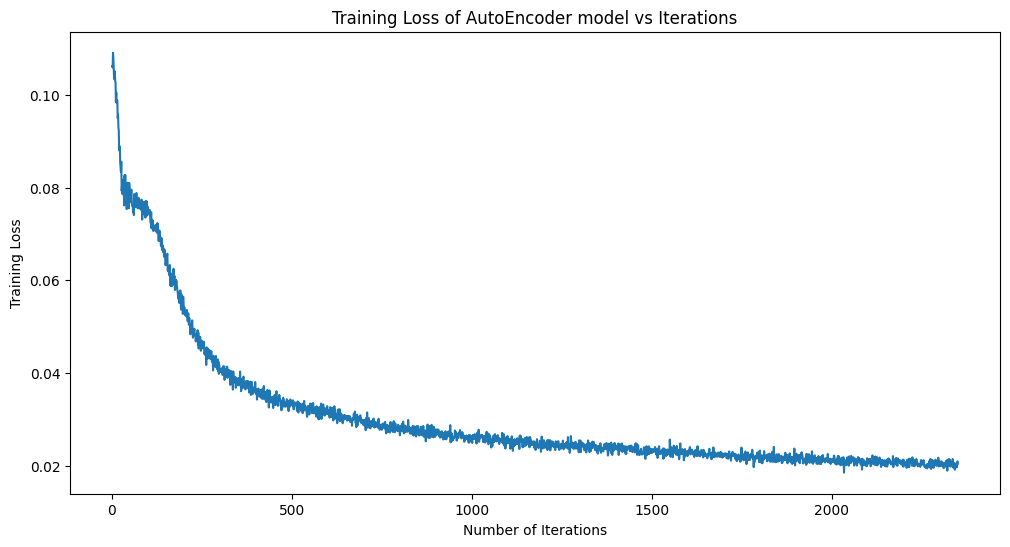

In [16]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1,len(training_loss)+1),training_loss)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss of AutoEncoder model vs Iterations")
plt.show()

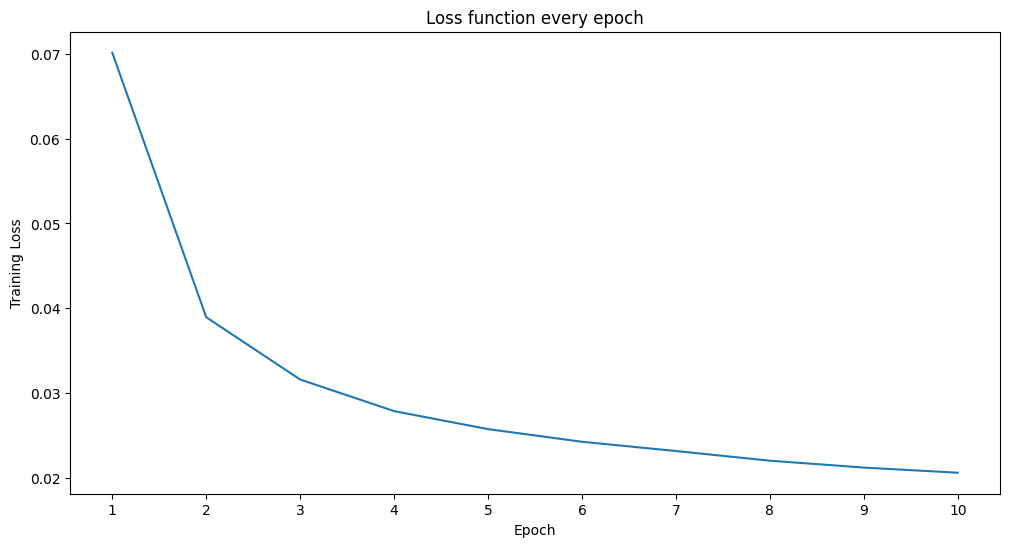

In [17]:
plt.plot(range(1,len(epoch_loss)+1), epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(np.arange(1, epochs+1, 1))
plt.title('Loss function every epoch')
plt.show()


Reconstruction Error in AE: 4.680068175990048
Reconstruction Error in PCA: 4.906911764827694


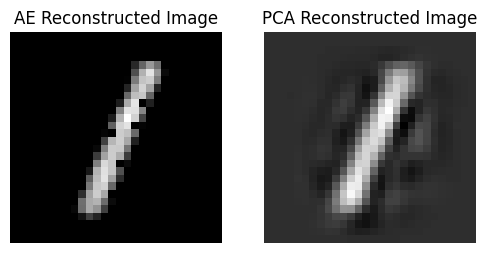


Reconstruction Error in AE: 20.137397784120566
Reconstruction Error in PCA: 16.862378249952226


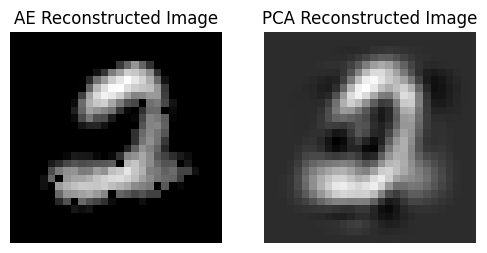


Reconstruction Error in AE: 25.641587574562777
Reconstruction Error in PCA: 16.045760637032934


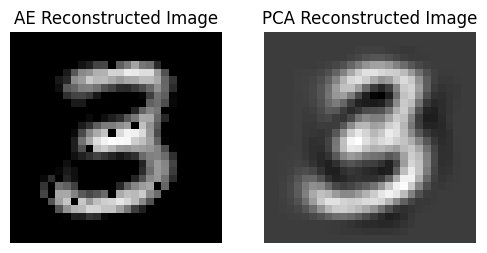


Reconstruction Error in AE: 15.058324125918803
Reconstruction Error in PCA: 10.714796757452177


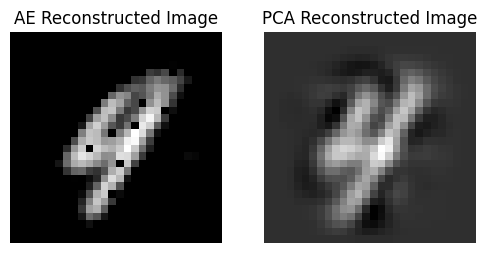


Reconstruction Error in AE: 18.54981946479171
Reconstruction Error in PCA: 14.848194203327743


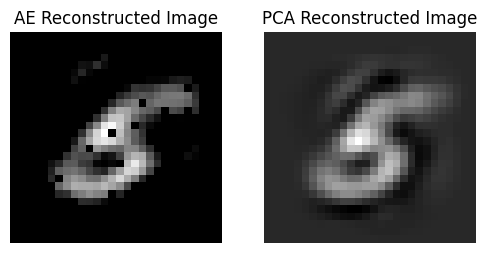


Reconstruction Error in AE: 29.477637663944755
Reconstruction Error in PCA: 20.39082317854006


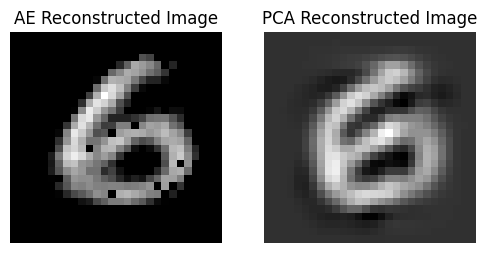


Reconstruction Error in AE: 16.91736239540976
Reconstruction Error in PCA: 11.735866845831769


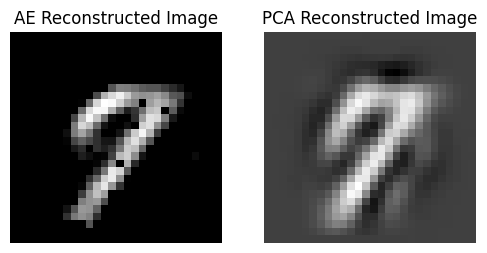


Reconstruction Error in AE: 19.7427275329733
Reconstruction Error in PCA: 14.356567563037238


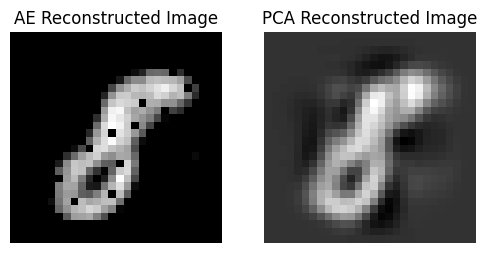


Reconstruction Error in AE: 14.054310091006618
Reconstruction Error in PCA: 13.215491086317673


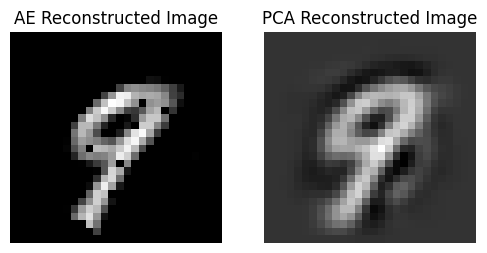


Reconstruction Error in AE: 22.26104982183423
Reconstruction Error in PCA: 16.605809403304725


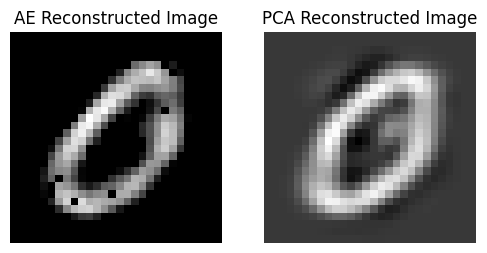

In [18]:
testset_example = torch.utils.data.DataLoader(dataset=testset.data[9705:9715],shuffle=False,batch_size=10)

model1.eval()
with torch.no_grad():
  for images in testset_example:
    images = images.reshape(10,28*28)
    outputs,_ = model1(images.float())

plt.rcParams["figure.figsize"] = (6,3)
for i in range (10):
  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.imshow(outputs[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('AE Reconstructed Image')
  ax1.axis("off")
  ax2.imshow(reconstructed_test_data[i].reshape(28,28),cmap='gray')
  ax2.set_title('PCA Reconstructed Image')
  ax2.axis("off")
  print()
  # Compute the square error between the original image and the reconstruction
  # I did the dot product = sum of the squared differences for all pixel values
  print("Reconstruction Error in AE:",np.dot(((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)).T))
  print("Reconstruction Error in PCA:",np.dot(((images[i].detach().numpy()/255)-(reconstructed_test_data[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(reconstructed_test_data[i].detach().numpy()/255)).T))
  plt.show()

It seems that, using squared error, PCA outperforms the autoencoder. This actually makes sense since PCA is a linear dimensionality reduction method and it actually tries to minimize the squared reconstruction error.

On the other hand, autoencoders has non-linearity inside the network, which allow them to capture more complex structures of the data (and therefore this is also the reason why they have managed to preserve more details such as the intensity and the contrast, as compared to PCA result, which is more blurred).

The "holes" (black pixels) in the AE reconstruction might happen because we didn't train the model enough or with enough data. I also think that a big role is given by the ReLu activation function, because it clippes the value to 0.



## Standard AutoEncoder

Design a under-complete AE with just one hidden layer that acts as dimensionality reduction for MNIST dataset. Keep the dimension of hidden layer (x) as a variable and train the network for different hidden unit dimensions. Check the reconstruction.

In [19]:
class StdAE2(nn.Module):
  def __init__(self, h_dim):
    super(StdAE2, self).__init__()
    self.hidden = h_dim
    self.encoder = nn.Sequential(
    nn.Linear(784,self.hidden),
    nn.ReLU()
    )
    self.decoder = nn.Sequential(
    nn.Linear(self.hidden,784),
    nn.ReLU()
    )

  def forward(self,x):
    x = self.encoder(x)
    encoded_output = x
    x = self.decoder(x)
    return x, encoded_output

Let x = [64, 128, 256]

In [20]:
x = [64, 128, 256]

model_64 = StdAE2(x[0])
criterion_64 = nn.MSELoss()
optimizer_64 = torch.optim.Adam(model_64.parameters(), lr=learning_rate)
epoch_loss_64, t_loss_64 = train_model(model_64, dataloaders['train'], criterion_64, optimizer_64, 10, device=device)

print("#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
model_128 = StdAE2(x[1])
criterion_128 = nn.MSELoss()
optimizer_128 = torch.optim.Adam(model_128.parameters(), lr=learning_rate)
epoch_loss_128, t_loss_128 = train_model(model_128, dataloaders['train'], criterion_128, optimizer_128, 10, device=device)

print("#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
model_256 = StdAE2(x[2])
criterion_256 = nn.MSELoss()
optimizer_256 = torch.optim.Adam(model_256.parameters(), lr=learning_rate)
epoch_loss_256, t_loss_256 = train_model(model_256, dataloaders['train'], criterion_256, optimizer_256, 10, device=device)

Epoch [1/10], Loss: 0.0543
Epoch [2/10], Loss: 0.0261
Epoch [3/10], Loss: 0.0195
Epoch [4/10], Loss: 0.0168
Epoch [5/10], Loss: 0.0152
Epoch [6/10], Loss: 0.0141
Epoch [7/10], Loss: 0.0133
Epoch [8/10], Loss: 0.0127
Epoch [9/10], Loss: 0.0123
Epoch [10/10], Loss: 0.0120
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
Epoch [1/10], Loss: 0.0423
Epoch [2/10], Loss: 0.0164
Epoch [3/10], Loss: 0.0117
Epoch [4/10], Loss: 0.0098
Epoch [5/10], Loss: 0.0088
Epoch [6/10], Loss: 0.0082
Epoch [7/10], Loss: 0.0078
Epoch [8/10], Loss: 0.0074
Epoch [9/10], Loss: 0.0072
Epoch [10/10], Loss: 0.0070
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
Epoch [1/10], Loss: 0.0328
Epoch [2/10], Loss: 0.0107
Epoch [3/10], Loss: 0.0078
Epoch [4/10], Loss: 0.0065
Epoch [5/10], Loss: 0.0058
Epoch [6/10], Loss: 0.0053
Epoch [7/10], Loss: 0.0049
Epoch [8/10], Loss: 0.0047
Epoch [9/10], Loss: 0.0045
Epoch [10/10], Loss: 0.0043


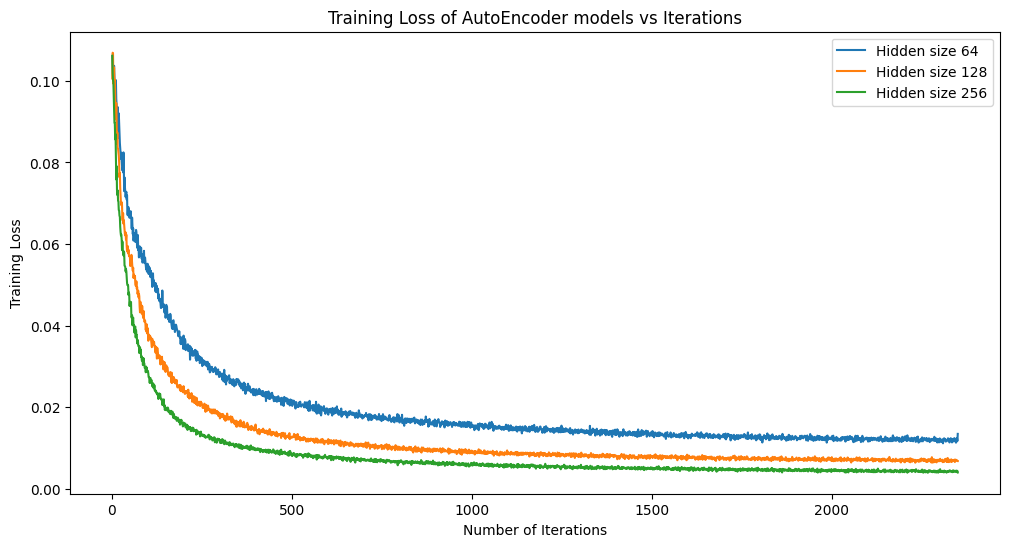

In [21]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1,len(t_loss_64)+1),t_loss_64,label="Hidden size 64")
plt.plot(range(1,len(t_loss_128)+1),t_loss_128,label="Hidden size 128")
plt.plot(range(1,len(t_loss_256)+1),t_loss_256,label="Hidden size 256")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss of AutoEncoder models vs Iterations")
plt.show()

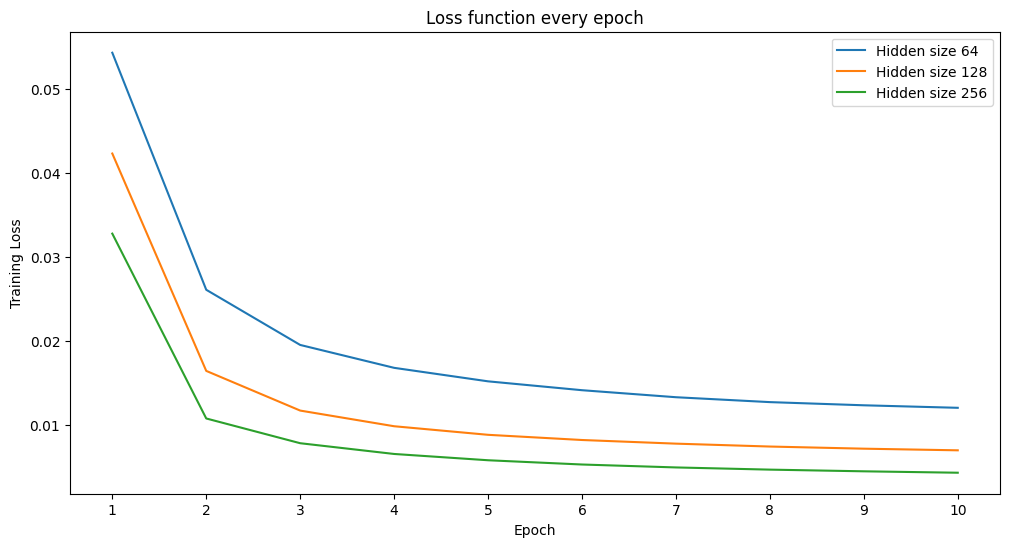

In [22]:
plt.plot(range(1,len(epoch_loss_64)+1),epoch_loss_64,label="Hidden size 64")
plt.plot(range(1,len(epoch_loss_128)+1),epoch_loss_128,label="Hidden size 128")
plt.plot(range(1,len(epoch_loss_256)+1),epoch_loss_256,label="Hidden size 256")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(np.arange(1, epochs+1, 1))
plt.title('Loss function every epoch')
plt.show()

Test the network on any one of your testset images and compare the quality of reconstruction for different values of x.

In [23]:
testset_example = torch.utils.data.DataLoader(dataset=testset.data[9705:9715],shuffle=False,batch_size=10)

# First I reconstruct the images
model_64.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid64,_ = model_64(images.float())

model_128.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid128,_ = model_128(images.float())

model_256.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid256,activations_hid256 = model_256(images.float())

Reconstruction Error in AE_hid64: 12.344127479528655
Reconstruction Error in AE_hid128: 7.293184998965914
Reconstruction Error in AE_hid256: 5.244607256549658


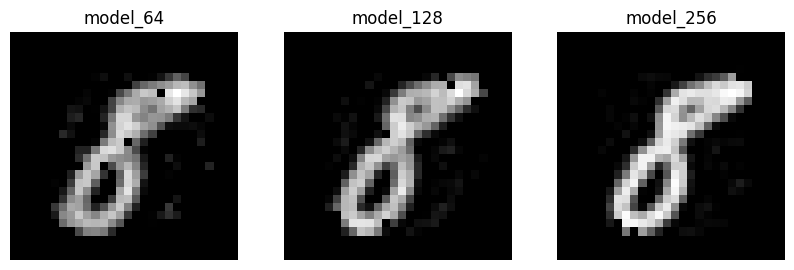

In [24]:
# Then as I did above (comparison between AE and PCA) I plot the digit and the reconstruction error between the three different AEs
plt.rcParams["figure.figsize"] = (10,6)
i = 7

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(outputs_hid64[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('model_64')
ax1.axis("off")
ax2.imshow(outputs_hid128[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('model_128')
ax2.axis("off")
ax3.imshow(outputs_hid256[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('model_256')
ax3.axis("off")
print("Reconstruction Error in AE_hid64:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)).T))
print("Reconstruction Error in AE_hid128:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)).T))
print("Reconstruction Error in AE_hid256:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)).T))

Of course the more neurons in the hidden layer, the more details can be captured by the encoder. In the 256 neurons net we can see there are more details regarding intensity, contrast, less "black holes". Moreover, a futher proof is given by the reconstruction error which is smaller than the simpler AEs.

What kind of reconstructions do you get when you pass non-digit images or random noise images as input to the auto-encoder?

#### Non-digit image

In [25]:
# I tried to import the KMINST (Kuzushiji-MNIST) consinsting in Japanese characters
testset_kmnist = datasets.KMNIST(root="./data",train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 18165135/18165135 [00:09<00:00, 1971988.75it/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 388496.36it/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:01<00:00, 1725070.95it/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 22486739.77it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



(-0.5, 27.5, 27.5, -0.5)

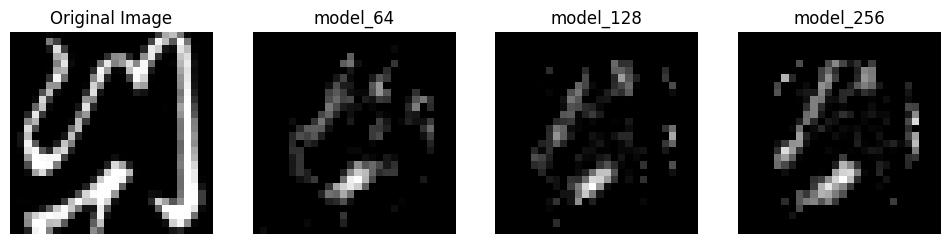

In [26]:
testset_kmnist_example = torch.utils.data.DataLoader(dataset=testset_kmnist.data[9705:9715],shuffle=False,batch_size=10)

model_64.eval()
with torch.no_grad():
  for images in testset_kmnist_example:
    #print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid64,_ = model_64(images.float())

model_128.eval()
with torch.no_grad():
  for images in testset_kmnist_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid128,_ = model_128(images.float())

model_256.eval()
with torch.no_grad():
  for images in testset_kmnist_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid256,_ = model_256(images.float())

plt.rcParams["figure.figsize"] = (12,6)
i = 5

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Image')
ax1.axis("off")
ax2.imshow(outputs_hid64[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('model_64')
ax2.axis("off")
ax3.imshow(outputs_hid128[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('model_128')
ax3.axis("off")
ax4.imshow(outputs_hid256[i].detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('model_256')
ax4.axis("off")

We can observe a poor reconstruction quality: the AE is trained to capture the features and patterns specific to MNIST digits. When it encounters images from the KMNIST dataset the model doesn't generalize well. Therefore there is blurring, incomplete shapes, distorsions,... This is of course expected since the model is trained to capture the important features of a digit! For example we can see that the reconstruction has always black on the outer pixels, even though the input image has white in the borders!

#### Random image

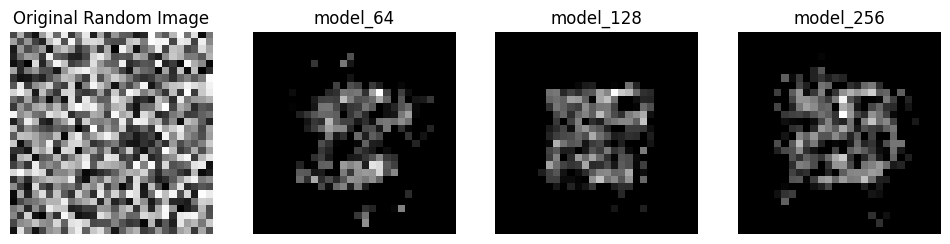

In [27]:
torch.manual_seed(548)
random_image=torch.randint(low=0, high=255,size=(1,28,28))

model_64.eval()
with torch.no_grad():
  images = random_image.reshape(1,28*28)
  outputs_hid64,_ = model_64(images.float())

model_128.eval()
with torch.no_grad():
  images = random_image.reshape(1,28*28)
  outputs_hid128,_ = model_128(images.float())

model_256.eval()
with torch.no_grad():
  images = random_image.reshape(1,28*28)
  outputs_hid256,_ = model_256(images.float())

plt.rcParams["figure.figsize"] = (12,6)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.imshow(random_image.numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Random Image')
ax1.axis("off")
ax2.imshow(outputs_hid64.detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('model_64')
ax2.axis("off")
ax3.imshow(outputs_hid128.detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('model_128')
ax3.axis("off")
ax4.imshow(outputs_hid256.detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('model_256')
ax4.axis("off")
plt.show()

As said above we can see again that the model tries to capture and then reconstruct features similar to the digits dataset. Again we can see the black pixels around the image, as the input images!

The weight vectors associated with each hidden node is called a filter. Try to visualize the learned filters of the standard AE as images. Does their structure make any sense to you? What do you think they represent?

In [28]:
filters = model_64.encoder[0].weight.data.cpu().numpy()
print(filters.shape) # every neuron in the hidden layer has 784 weights

(64, 784)


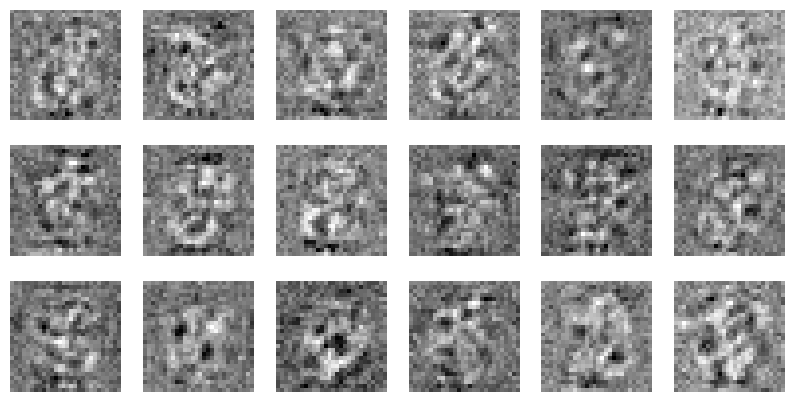

In [29]:
plt.rcParams["figure.figsize"] = (10,5)
for i, filter in enumerate(filters[:18]):
    filter_image = filter.reshape(28, 28)
    plt.subplot(3, 6, i+1)
    plt.imshow(filter_image, cmap='gray')
    plt.axis('off')
plt.show()

We should see the features that the model is learning. The "problem" here is that the neurons in the hidden layer are quite a lot therefore we might see more complex "combination"/relationship between pixels, complex features, etc.

## Sparse AutoEncoder

 Design an over-complete AE with sparsity regularization (Check L1Penalty in torch). We impose sparsity by adding L1 penalty on the hidden layer activation.

In [30]:
class Sparse_AE(nn.Module):
  def __init__(self, sparsity_reg):
    super(Sparse_AE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,1156),
        nn.ReLU())
    self.decoder = nn.Sequential(
        nn.Linear(1156,784),
        nn.ReLU())
    self.sparsity_reg = sparsity_reg  # L1 regularization parameter

  def forward(self,x):
    x = self.encoder(x)
    encoded_output = x
    # Sparsity regularization
    reg_loss = self.sparsity_reg*torch.norm(x,p=1) # L1 regularization
    x = self.decoder(x)
    return x,reg_loss,encoded_output

In [31]:
# I made a new function to take into account the regularization
def train_sparsemodel(model, dataloader, loss_fn, optimizer, num_epochs=5, device='cpu'):
    """
    Train the model given the data. For num_epochs of time the model is trained, which
    means that, based on the backward propagation, the weights (params) are adjusted.
    The loss function is also saved so to understand if the model is actually learning well.
    :param:
    model: desired network to be trained
    dataloader: torch loader of the training data (inputs and labels)
    loss_fn: loss function to use during the training of the network
    optimizer: optimizer to use during the training of the network
    num_epochs: for how many epochs the model will be trained?
    device: in this case just cpu is available since I'm working with numpy

    :return:
    epoch_loss: list of loss function for every epoch (in total num_epochs values)
    """
    model.train()
    epoch_loss = []
    training_loss = []
    running_loss = 0

    for epoch in range(num_epochs):
      running_loss = 0  # Reset running_loss for each epoch
      for inputs, labels in dataloader:
        inputs = inputs.reshape(inputs.shape[0],-1)
        outputs,l1_loss,_ = model(inputs)
        loss = loss_fn(outputs,inputs)+l1_loss # Add regularization here
        running_loss += loss.item() * inputs.size(0)
        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      epoch_loss.append(running_loss/len(dataloader.dataset))
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss[-1]:.4f}')
    return epoch_loss, training_loss

In [32]:
learning_rate = 3e-4 # karpathy's constant
epochs = 5

sparsity_reg = [4*1e-6 , 1.5*1e-6, 0.6*1e-6]

model3a = Sparse_AE(sparsity_reg[0])
criterion3a = nn.MSELoss()
optimizer3a = torch.optim.Adam(model3a.parameters(), lr=learning_rate)
epoch_loss3a, training_loss3a = train_sparsemodel(model3a, dataloaders['train'], criterion3a, optimizer3a, epochs, device=device)

print("#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
model3b = Sparse_AE(sparsity_reg[1])
criterion3b = nn.MSELoss()
optimizer3b = torch.optim.Adam(model3b.parameters(), lr=learning_rate)
epoch_loss3b, training_loss3b = train_sparsemodel(model3b, dataloaders['train'], criterion3b, optimizer3b, epochs, device=device)

print("#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
model3c = Sparse_AE(sparsity_reg[2])
criterion3c = nn.MSELoss()
optimizer3c = torch.optim.Adam(model3c.parameters(), lr=learning_rate)
epoch_loss3c, training_loss3c = train_sparsemodel(model3c, dataloaders['train'], criterion3c, optimizer3c, epochs, device=device)

Epoch [1/5], Loss: 0.0754
Epoch [2/5], Loss: 0.0445
Epoch [3/5], Loss: 0.0389
Epoch [4/5], Loss: 0.0363
Epoch [5/5], Loss: 0.0346
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
Epoch [1/5], Loss: 0.0494
Epoch [2/5], Loss: 0.0248
Epoch [3/5], Loss: 0.0203
Epoch [4/5], Loss: 0.0180
Epoch [5/5], Loss: 0.0165
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
Epoch [1/5], Loss: 0.0359
Epoch [2/5], Loss: 0.0163
Epoch [3/5], Loss: 0.0131
Epoch [4/5], Loss: 0.0115
Epoch [5/5], Loss: 0.0106


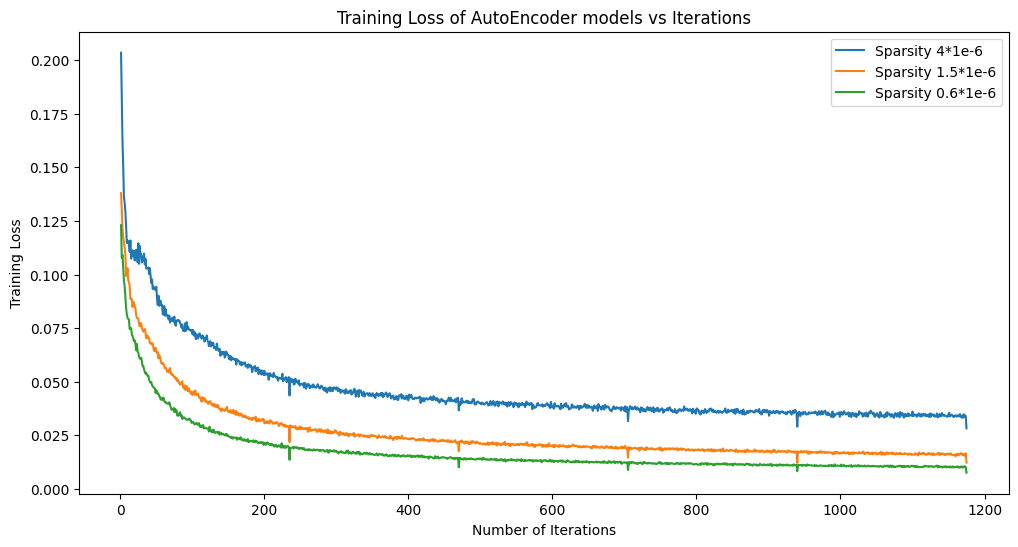

In [33]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1,len(training_loss3a)+1),training_loss3a,label="Sparsity 4*1e-6")
plt.plot(range(1,len(training_loss3b)+1),training_loss3b,label="Sparsity 1.5*1e-6")
plt.plot(range(1,len(training_loss3c)+1),training_loss3c,label="Sparsity 0.6*1e-6")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss of AutoEncoder models vs Iterations")
plt.show()

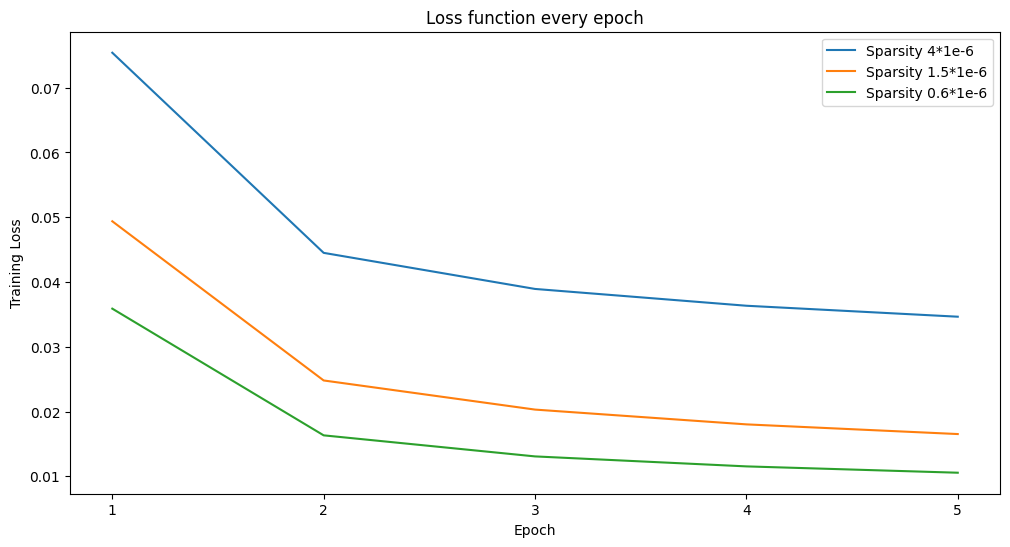

In [34]:
plt.plot(range(1,len(epoch_loss3a)+1),epoch_loss3a,label="Sparsity 4*1e-6")
plt.plot(range(1,len(epoch_loss3b)+1),epoch_loss3b,label="Sparsity 1.5*1e-6")
plt.plot(range(1,len(epoch_loss3c)+1),epoch_loss3c,label="Sparsity 0.6*1e-6")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(np.arange(1, epochs+1, 1))
plt.title('Loss function every epoch')
plt.show()

As we can see the bigger the regularization parameter the higher the loss function. This is quite obvious also in mathematical terms, since we're summing the regularization part. ie: the model needs to find a balance between reconstructing the input and maintaining sparse activations.

In [35]:
testset_example = torch.utils.data.DataLoader(dataset=testset.data[9705:9715],shuffle=False,batch_size=10)

# First I reconstruct the images
model3a.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hida,_,activation3a = model3a(images.float())

model3b.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hidb,_,activation3b = model3b(images.float())

model3c.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hidc,_,activation3c = model3c(images.float())

Reconstruction Error in Model3a: 18.661011526632535
Reconstruction Error in Model3b: 17.51135038485359
Reconstruction Error in Model3c: 23.967658199365104


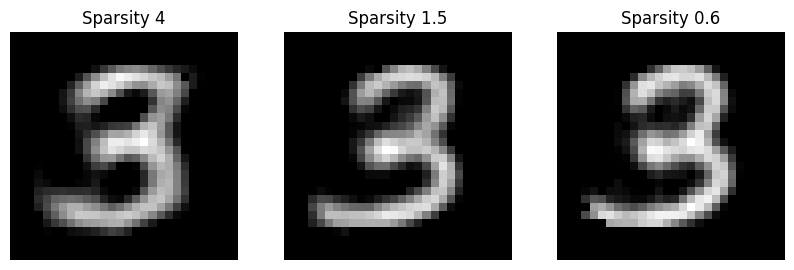

In [36]:
plt.rcParams["figure.figsize"] = (10,6)
i = 2

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(outputs_hida[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Sparsity 4')
ax1.axis("off")
ax2.imshow(outputs_hidb[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('Sparsity 1.5')
ax2.axis("off")
ax3.imshow(outputs_hidc[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('Sparsity 0.6')
ax3.axis("off")
print("Reconstruction Error in Model3a:",np.dot(((images[i].detach().numpy()/255)-(outputs_hida[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hida[i].detach().numpy()/255)).T))
print("Reconstruction Error in Model3b:",np.dot(((images[i].detach().numpy()/255)-(outputs_hidb[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hidb[i].detach().numpy()/255)).T))
print("Reconstruction Error in Model3c:",np.dot(((images[i].detach().numpy()/255)-(outputs_hidc[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hidc[i].detach().numpy()/255)).T))

As said in the assignment, when the regularization parameter is too big the reconstruction is not good. This is expected since we are basically switching off too many neurons in the hidden layer, if too few hidden units are active, the network lacks the capacity to capture enough information about the input.

Compare the average hidden layer activations of the Sparse AE with that of the Standard AE (in the above question). What difference do you observe between the two?

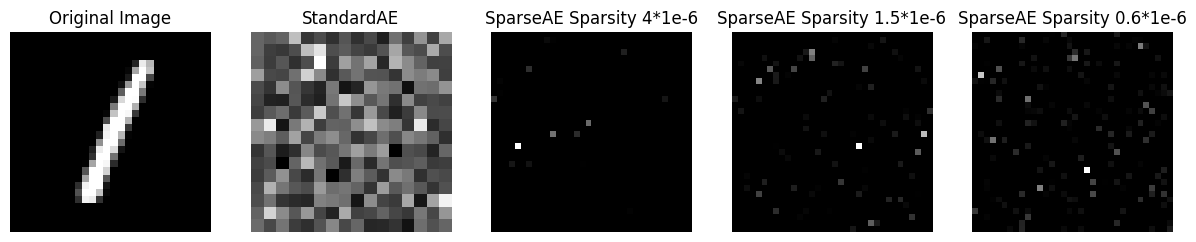

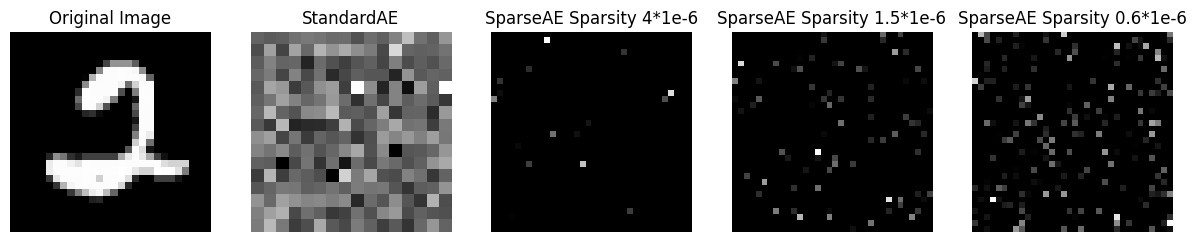

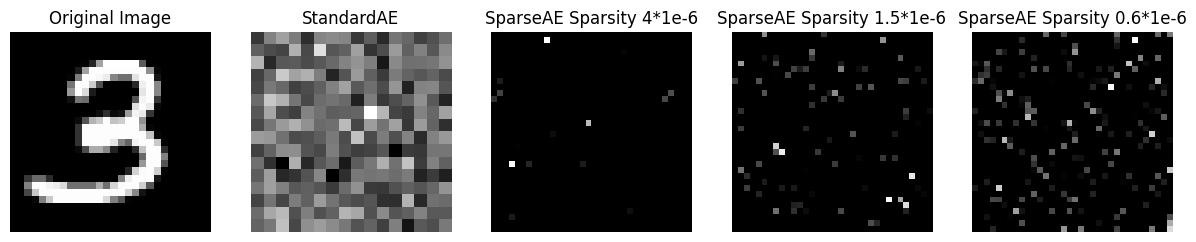

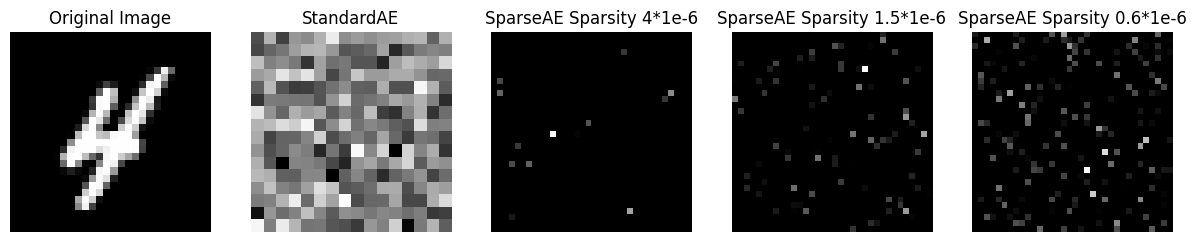

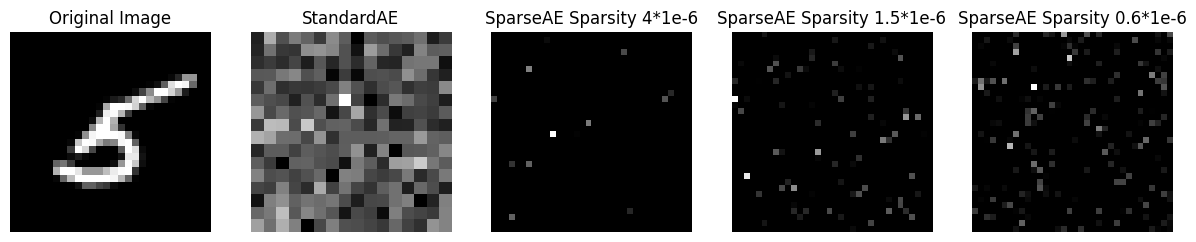

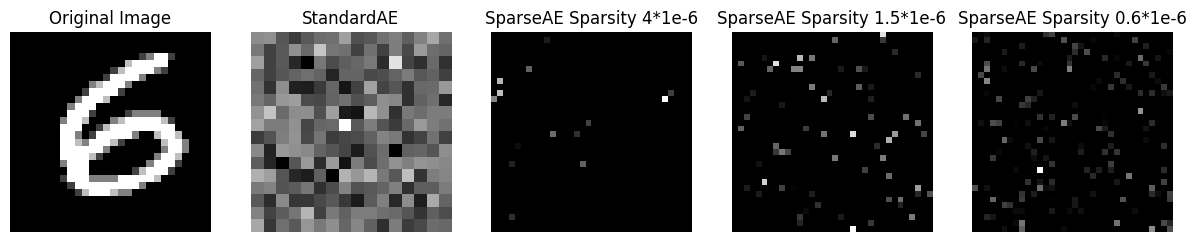

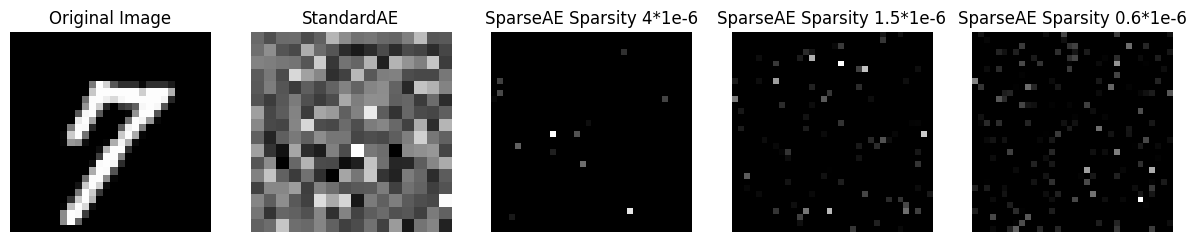

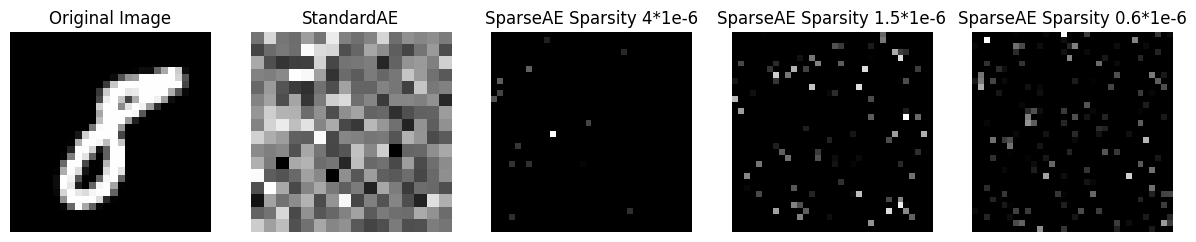

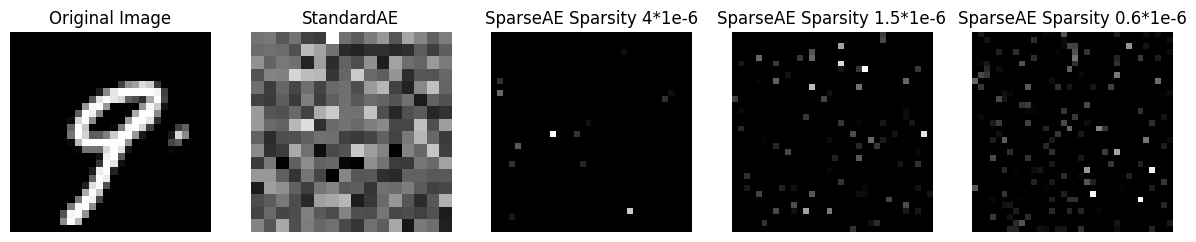

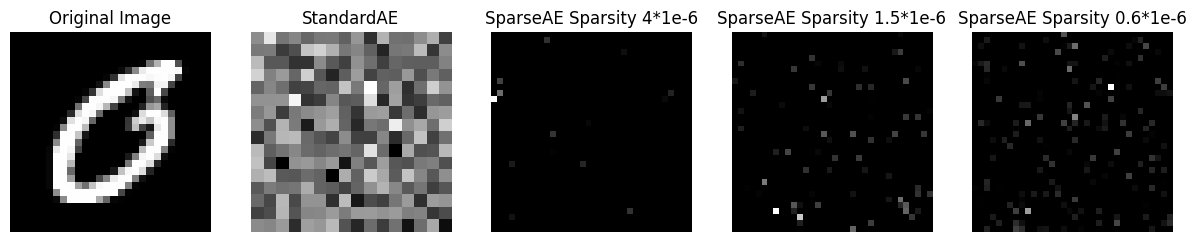

In [37]:
plt.rcParams["figure.figsize"] = (15,6)
for i in range(10):
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)
  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")
  ax2.imshow(np.array(activations_hid256.detach().numpy())[i].reshape(int(np.sqrt(256)),int(np.sqrt(256))),cmap='gray')
  ax2.set_title('StandardAE')
  ax2.axis("off")
  ax3.imshow(np.array(activation3a.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax3.set_title('SparseAE Sparsity 4*1e-6')
  ax3.axis("off")
  ax4.imshow(np.array(activation3b.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax4.set_title('SparseAE Sparsity 1.5*1e-6')
  ax4.axis("off")
  ax5.imshow(np.array(activation3c.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax5.set_title('SparseAE Sparsity 0.6*1e-6')
  ax5.axis("off")
plt.show()

By visualizing the encoded image we can see the effect of the regularization: many of the neurons are switched to zero (black pixels!!). As expected in the case of smaller regularization parameter the active neurons are more!
NB: in the standard autoencoder ALL the neurons are active, therefore by regularizing we are forcing the model to learn only really important features of the input.

Now, try to visualize the learned filters of this Sparse AE as images. What difference do you observe in the structure of these filters from the ones you learned using the Standard AE?

In [38]:
filters = model3a.encoder[0].weight.detach().numpy()
print(filters.shape) # every neuron in the hidden layer has 784 weights

(1156, 784)


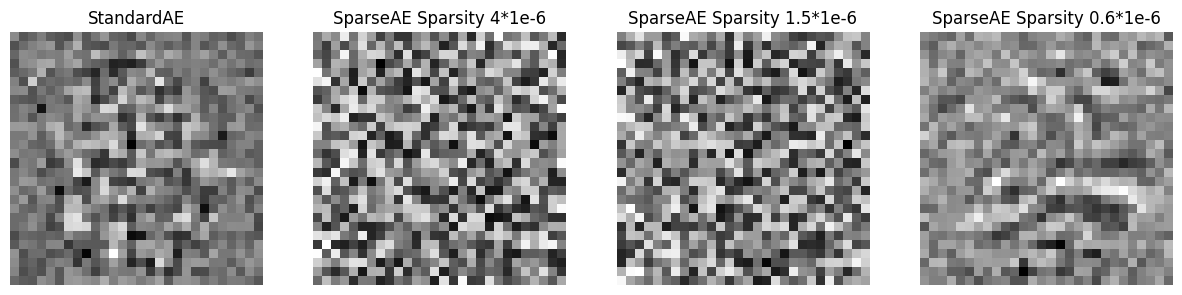

In [39]:
plt.rcParams["figure.figsize"] = (15,6)
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(model_256.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax1.set_title('StandardAE')
ax1.axis("off")
ax2.imshow(model3a.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax2.set_title('SparseAE Sparsity 4*1e-6')
ax2.axis("off")
ax3.imshow(model3b.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax3.set_title('SparseAE Sparsity 1.5*1e-6')
ax3.axis("off")
ax4.imshow(model3c.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax4.set_title('SparseAE Sparsity 0.6*1e-6')
ax4.axis("off")
plt.show()

It is difficult to interpret the weights. But we can see that in the standard AE there seems some pattern in the center, while in the sparse AE there is not visible pattern. The weights seem though to reflect the idea behind regularization (switching off some neurons).

## Denoising AutoEncoder
Design a denoising AE with just one hidden unit.

In [40]:
class DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super(DenoisingAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
    nn.Linear(784,256),
    nn.ReLU())
    self.decoder = nn.Sequential(
    nn.Linear(256,784),
    nn.ReLU())
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

In [41]:
def rnd_noise(img, noise_val):
  noise = torch.randn(img.size())*noise_val
  noisy_img = img + noise
  return noisy_img

def salt_and_pepper_noise(img, noise_val):
    ratio = 0.9
    noisy = np.copy(img)

    salt_count = np.ceil(noise_val * img.size * ratio)
    coords = [np.random.randint(0, i - 1, int(salt_count)) for i in img.shape]
    noisy[coords] = 1
    pepper_count = np.ceil(noise_val * img.size * (1. - ratio))
    coords = [np.random.randint(0, i - 1, int(pepper_count)) for i in img.shape]
    noisy[coords] = 0
    return noisy

In [42]:
# I made a new function to take into account the regularization
def train_sparsemodel(model, dataloader, loss_fn, optimizer, num_epochs=5, noise_amount=0, device='cpu'):
    """
    Train the model given the data. For num_epochs of time the model is trained, which
    means that, based on the backward propagation, the weights (params) are adjusted.
    The loss function is also saved so to understand if the model is actually learning well.
    :param:
    model: desired network to be trained
    dataloader: torch loader of the training data (inputs and labels)
    loss_fn: loss function to use during the training of the network
    optimizer: optimizer to use during the training of the network
    num_epochs: for how many epochs the model will be trained?
    device: in this case just cpu is available since I'm working with numpy

    :return:
    epoch_loss: list of loss function for every epoch (in total num_epochs values)
    """
    model.train()
    epoch_loss = []
    training_loss = []
    running_loss = 0

    for epoch in range(num_epochs):
      running_loss = 0  # Reset running_loss for each epoch
      for inputs, labels in dataloader:
        inputs = inputs.reshape(inputs.shape[0],-1)
        noisy_inputs = rnd_noise(inputs, noise_amount)
        outputs = model(noisy_inputs)
        loss = loss_fn(outputs,inputs)
        running_loss += loss.item() * inputs.size(0)
        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      epoch_loss.append(running_loss/len(dataloader.dataset))
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss[-1]:.4f}')
    return epoch_loss, training_loss

In [43]:
learning_rate = 0.00008
epochs = 5

noise = [0.3, 0.5, 0.8, 0.9]

model4a = DenoisingAutoencoder()
criterion4a = nn.MSELoss()
optimizer4a = torch.optim.Adam(model4a.parameters(), lr=learning_rate)
epoch_loss4a, training_loss4a = train_sparsemodel(model4a, dataloaders['train'], criterion4a, optimizer4a, epochs, noise[0], device=device)

print("#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
model4b = DenoisingAutoencoder()
criterion4b = nn.MSELoss()
optimizer4b = torch.optim.Adam(model4b.parameters(), lr=learning_rate)
epoch_loss4b, training_loss4b = train_sparsemodel(model4b, dataloaders['train'], criterion4b, optimizer4b, epochs, noise[1], device=device)

print("#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
model4c = DenoisingAutoencoder()
criterion4c = nn.MSELoss()
optimizer4c = torch.optim.Adam(model4c.parameters(), lr=learning_rate)
epoch_loss4c, training_loss4c = train_sparsemodel(model4c, dataloaders['train'], criterion4c, optimizer4c, epochs, noise[2], device=device)

print("#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
model4d = DenoisingAutoencoder()
criterion4d = nn.MSELoss()
optimizer4d = torch.optim.Adam(model4d.parameters(), lr=learning_rate)
epoch_loss4d, training_loss4d = train_sparsemodel(model4d, dataloaders['train'], criterion4d, optimizer4d, epochs, noise[3], device=device)

Epoch [1/5], Loss: 0.0592
Epoch [2/5], Loss: 0.0286
Epoch [3/5], Loss: 0.0203
Epoch [4/5], Loss: 0.0167
Epoch [5/5], Loss: 0.0148
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
Epoch [1/5], Loss: 0.0645
Epoch [2/5], Loss: 0.0359
Epoch [3/5], Loss: 0.0274
Epoch [4/5], Loss: 0.0237
Epoch [5/5], Loss: 0.0217
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
Epoch [1/5], Loss: 0.0715
Epoch [2/5], Loss: 0.0460
Epoch [3/5], Loss: 0.0373
Epoch [4/5], Loss: 0.0332
Epoch [5/5], Loss: 0.0309
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
Epoch [1/5], Loss: 0.0741
Epoch [2/5], Loss: 0.0494
Epoch [3/5], Loss: 0.0404
Epoch [4/5], Loss: 0.0362
Epoch [5/5], Loss: 0.0339


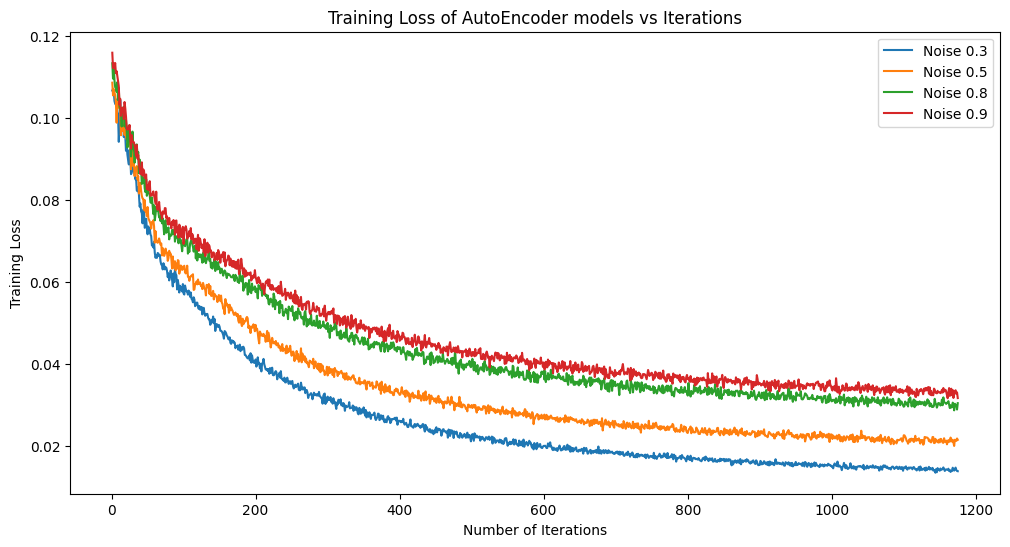

In [44]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1,len(training_loss4a)+1),training_loss4a,label=f"Noise {noise[0]}")
plt.plot(range(1,len(training_loss4b)+1),training_loss4b,label=f"Noise {noise[1]}")
plt.plot(range(1,len(training_loss4c)+1),training_loss4c,label=f"Noise {noise[2]}")
plt.plot(range(1,len(training_loss4d)+1),training_loss4d,label=f"Noise {noise[3]}")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss of AutoEncoder models vs Iterations")
plt.show()

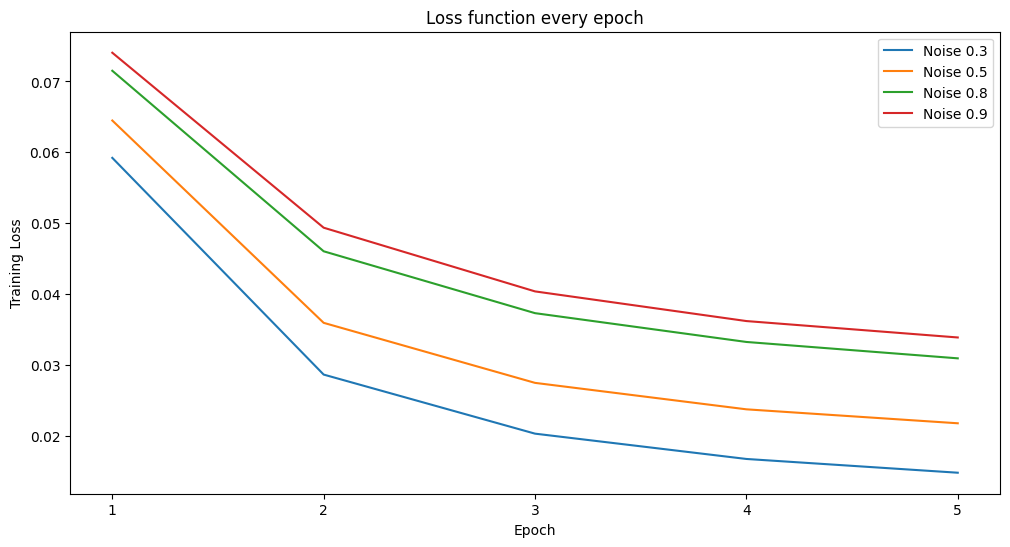

In [45]:
plt.plot(range(1,len(epoch_loss4a)+1),epoch_loss4a,label=f"Noise {noise[0]}")
plt.plot(range(1,len(epoch_loss4b)+1),epoch_loss4b,label=f"Noise {noise[1]}")
plt.plot(range(1,len(epoch_loss4c)+1),epoch_loss4c,label=f"Noise {noise[2]}")
plt.plot(range(1,len(epoch_loss4d)+1),epoch_loss4d,label=f"Noise {noise[3]}")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(np.arange(1, epochs+1, 1))
plt.title('Loss function every epoch')
plt.show()

As we can see above the more the noise we add in the input image the higher the loss function. This is mathematically obvious: we are computing the Loss by comparing the clean image with the reconstruction of the Net, made by using a noise image, therefore the more the noise the more difficult is for the image to "reach" good results!

- What happens when you pass images corrupted with noise to the previously trained Standard AEs?

- Change the noise level (typical values: 0.3, 0.5, 0.8, 0.9) and repeat the above experiments. What kind of variations do you observe in the results.

Reconstruction Error in StdAE with noise factor = 0.3: 7.715816308404816
Reconstruction Error in StdAE with noise factor = 0.5: 7.735576919524617
Reconstruction Error in StdAE with noise factor = 0.8: 7.724517651156634
Reconstruction Error in StdAE with noise factor = 0.9: 7.713649742207036


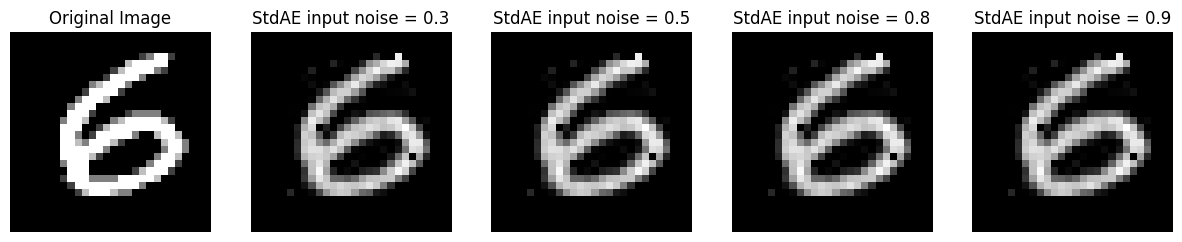

In [46]:
testset_example = torch.utils.data.DataLoader(dataset=testset.data[9705:9715],shuffle=False,batch_size=10)

model_256.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[0])
    outputs_hid256_03, activations_hid256 = model_256(noisy_images.float())

model_256.eval()
with torch.no_grad():
  for images in testset_example:
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[1])
    outputs_hid256_05,activations_hid256 = model_256(noisy_images.float())

model_256.eval()
with torch.no_grad():
  for images in testset_example:
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[2])
    outputs_hid256_08,activations_hid256 = model_256(noisy_images.float())

model_256.eval()
with torch.no_grad():
  for images in testset_example:
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[3])
    outputs_hid256_09,activations_hid256 = model_256(noisy_images.float())

plt.rcParams["figure.figsize"] = (15,6)
i=5
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)
ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Image')
ax1.axis("off")
ax2.imshow(outputs_hid256_03[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title(f'StdAE input noise = {noise[0]}')
ax2.axis("off")
ax3.imshow(outputs_hid256_05[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title(f'StdAE input noise = {noise[1]}')
ax3.axis("off")
ax4.imshow(outputs_hid256_08[i].detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title(f'StdAE input noise = {noise[2]}')
ax4.axis("off")
ax5.imshow(outputs_hid256_09[i].detach().numpy().reshape(28,28),cmap='gray')
ax5.set_title(f'StdAE input noise = {noise[3]}')
ax5.axis("off")
print(f"Reconstruction Error in StdAE with noise factor = {noise[0]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)).T))
print(f"Reconstruction Error in StdAE with noise factor = {noise[1]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_05[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_05[i].detach().numpy()/255.)).T))
print(f"Reconstruction Error in StdAE with noise factor = {noise[2]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_08[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_08[i].detach().numpy()/255.)).T))
print(f"Reconstruction Error in StdAE with noise factor = {noise[3]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_09[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_09[i].detach().numpy()/255.)).T))

The standard AE hasn't learned to deal with noise, therefore we can see the black pixels simply because it has not been trained on noisy data. The outputs seem really similar between each others. I think the reason is because the model is still able to get the necessary features to reconstruct the final digit that has been "memorize" in the filters. It basically ignore the noise to extract familiar features.

Reconstruction Error in StdAE with noise factor = 0.3: 11.307775158733618
Reconstruction Error in StdAE with noise factor = 0.5: 16.99680094761871
Reconstruction Error in StdAE with noise factor = 0.8: 21.492079945874426
Reconstruction Error in StdAE with noise factor = 0.9: 26.76831088367517


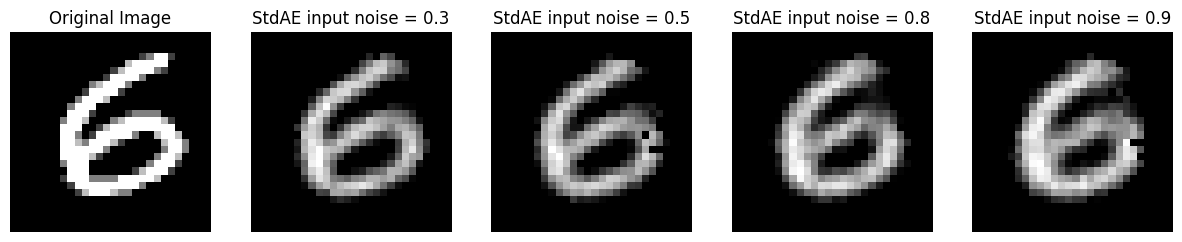

In [47]:
testset_example = torch.utils.data.DataLoader(dataset=testset.data[9705:9715],shuffle=False,batch_size=10)

model4a.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[0])
    outputs_hid4a = model4a(noisy_images.float())

model4b.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[1])
    outputs_hid4b = model4b(noisy_images.float())

model4c.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[2])
    outputs_hid4c = model4c(noisy_images.float())

model4d.eval()
with torch.no_grad():
  for images in testset_example:
    # print(images.shape)
    images = images.reshape(10,28*28)
    noisy_images = rnd_noise(images,noise[3])
    outputs_hid4d = model4d(noisy_images.float())

plt.rcParams["figure.figsize"] = (15,6)
i=5
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)
ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Image')
ax1.axis("off")
ax2.imshow(outputs_hid4a[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title(f'StdAE input noise = {noise[0]}')
ax2.axis("off")
ax3.imshow(outputs_hid4b[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title(f'StdAE input noise = {noise[1]}')
ax3.axis("off")
ax4.imshow(outputs_hid4c[i].detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title(f'StdAE input noise = {noise[2]}')
ax4.axis("off")
ax5.imshow(outputs_hid4d[i].detach().numpy().reshape(28,28),cmap='gray')
ax5.set_title(f'StdAE input noise = {noise[3]}')
ax5.axis("off")
print(f"Reconstruction Error in StdAE with noise factor = {noise[0]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid4a[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid4a[i].detach().numpy()/255.)).T))
print(f"Reconstruction Error in StdAE with noise factor = {noise[1]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid4b[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid4b[i].detach().numpy()/255.)).T))
print(f"Reconstruction Error in StdAE with noise factor = {noise[2]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid4c[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid4c[i].detach().numpy()/255.)).T))
print(f"Reconstruction Error in StdAE with noise factor = {noise[3]}:",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid4d[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid4d[i].detach().numpy()/255.)).T))

In these reconstructions we can see reduced contrast and intensity. Since the DAE was trained to remove noise, it sometimes applies excessive denoising, leading to slightly "blurred" or less sharp images. It's a trade-off we need to pay.

Visualize the learned filters for Denoising AEs. Compare it with that of Standard AEs. What difference do you observe between them?

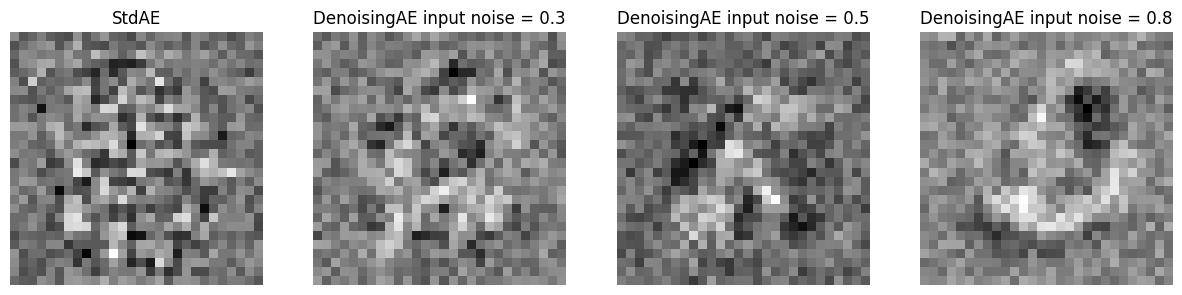

In [48]:
plt.rcParams["figure.figsize"] = (15,6)
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(model_256.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax1.set_title('StdAE')
ax1.axis("off")
ax2.imshow(model4a.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax2.set_title(f'DenoisingAE input noise = {noise[0]}')
ax2.axis("off")
ax3.imshow(model4b.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax3.set_title(f'DenoisingAE input noise = {noise[1]}')
ax3.axis("off")
ax4.imshow(model4c.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax4.set_title(f'DenoisingAE input noise = {noise[2]}')
ax4.axis("off")
plt.show()

## Manifold Learning

- Take an input data from MNIST. Try moving in random directions (i.e add random
 noise to it). This implies in a 784-dimensional space, if you randomly sample or randomly move in different direction you end up not getting a valid digit. Why is it so?


(-0.5, 27.5, 27.5, -0.5)

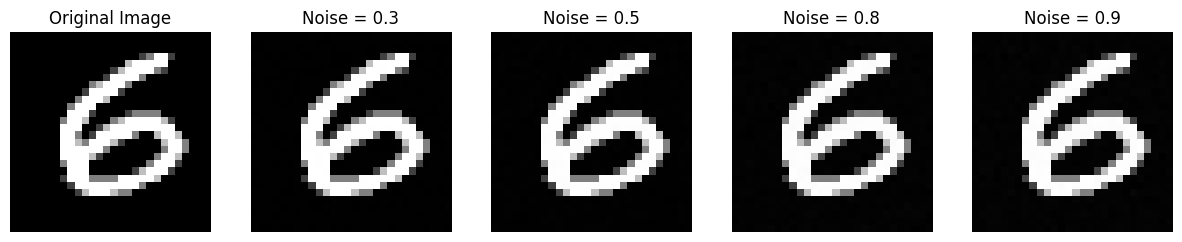

In [49]:
# First I get a random image
testset_example = torch.utils.data.DataLoader(dataset=testset.data[9705:9715],shuffle=False,batch_size=10)
noise = [0.3, 0.5, 0.8, 0.9]

plt.rcParams["figure.figsize"] = (15,6)
i=5
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)
ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Image')
ax1.axis("off")

noisy_image0 = rnd_noise(images, noise[0])
ax2.imshow(noisy_image0[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title(f'Noise = {noise[0]}')
ax2.axis("off")

noisy_image1 = rnd_noise(images, noise[1])
ax3.imshow(noisy_image1[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title(f'Noise = {noise[1]}')
ax3.axis("off")

noisy_image2 = rnd_noise(images, noise[2])
ax4.imshow(noisy_image2[i].detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title(f'Noise = {noise[2]}')
ax4.axis("off")

noisy_image3 = rnd_noise(images, noise[3])
ax5.imshow(noisy_image3[i].detach().numpy().reshape(28,28),cmap='gray')
ax5.set_title(f'Noise = {noise[3]}')
ax5.axis("off")

You generally do not get valid digits because this space is sparsely populated with valid data points and in a 784-dimensional space the possible values are almost infinite! So if you randomly move around this space is very likely to end up with not-clear images.

Now train an AE with the following configuration: input-fc(64)-fc(8)-fc(64)-fc(784)

In [50]:
class StdAE5(nn.Module):
  def __init__(self):
    super(StdAE5, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(784,64),
      nn.ReLU(),
      nn.Linear(64,8),
      nn.ReLU())
    self.decoder =nn.Sequential(
      nn.Linear(8,64),
      nn.ReLU(),
      nn.Linear(64,784),
      nn.ReLU())

  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    x=self.decoder(x)
    return x,encoded_output

In [51]:
learning_rate = 3e-4 # karpathy's constant
epochs = 10

model5 = StdAE5()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model5.parameters(),lr=learning_rate)

In [52]:
epoch_loss, training_loss = train_model(model5, dataloaders['train'], criterion, optimizer, epochs, device=device)

Epoch [1/10], Loss: 0.0731
Epoch [2/10], Loss: 0.0509
Epoch [3/10], Loss: 0.0466
Epoch [4/10], Loss: 0.0444
Epoch [5/10], Loss: 0.0433
Epoch [6/10], Loss: 0.0426
Epoch [7/10], Loss: 0.0421
Epoch [8/10], Loss: 0.0416
Epoch [9/10], Loss: 0.0409
Epoch [10/10], Loss: 0.0406


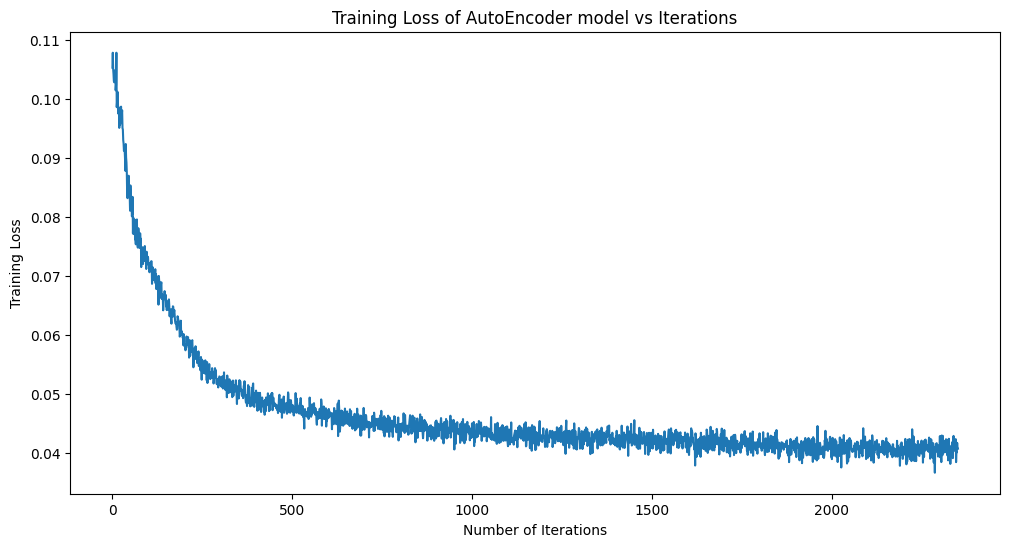

In [53]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1,len(training_loss)+1),training_loss)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss of AutoEncoder model vs Iterations")
plt.show()

After the network converges, pass an image from the test set. Add noise to the representation and try to reconstruct the data. What do you observe and why? Relate with manifold learning.

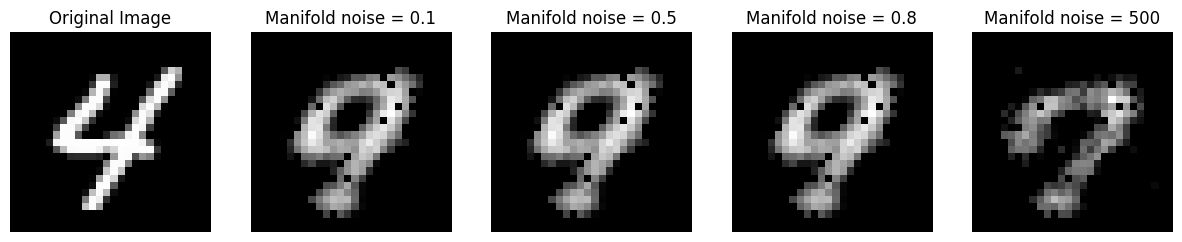

In [54]:
testset_example = torch.utils.data.DataLoader(dataset=testset.data[8222:9715],shuffle=False,batch_size=1)
noises = [0.1, 0.5, 0.8, 500]

model5.eval()

images = next(iter(testset_example))
images = images.view(-1, 784)

plt.rcParams["figure.figsize"] = (15,6)
fig, axes = plt.subplots(1,5)
axes[0].imshow(images.detach().numpy().reshape(28,28),cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis("off")

for i, noise in enumerate(noises):
  with torch.no_grad():
    manifold = model5.encoder(images.float()) # Get the manifold
    # print(manifold)

  # Add noise to the manifold
  manifold_noise = rnd_noise(manifold, noise)

  # And then reconstruct the image from the noisy manifold
  with torch.no_grad():
      reconstructed_image = model5.decoder(manifold_noise)

  axes[i+1].imshow(reconstructed_image.view(28, 28).cpu().numpy().reshape(28,28),cmap='gray')
  axes[i+1].set_title(f'Manifold noise = {noise}')
  axes[i+1].axis("off")

It seems the network is insensitive to small perturbations. Which means the AE ha learned a strong mapping between the input and the manifold therefore there is not a big change between small changes of the noise. When the noise is a lot then we can see that the net is not able to reconstruct the digit anymore.

Might also be the activation function (ReLU)?? The AE can saturate which means that if most of the neurons in the HL are near zero then addiing noise to those zeros do not affect much the result.

In the above example is interesting to see that by adding some noise to the manifold the net ends up recreating something similar to a 9, instead of a 4.

## Convolutional Autoencoders

Input:
- Conv1 (8 3x3 filters with stride 1)
- 2x2 Maxpooling
- Conv2 (16 3x3 filters with stride 1)
- 2x2 Maxpooling
- Conv3 (16 3x3 filters with stride 1)
- 2x2 Maxpooling


In [55]:
def train_ConvAE(model, dataloader, loss_fn, optimizer, num_epochs=5, device='cpu'):
    """
    """
    model.train()
    epoch_loss = []
    training_loss = []
    running_loss = 0

    for epoch in range(num_epochs):
      running_loss = 0  # Reset running_loss for each epoch
      for inputs, labels in dataloader:
        outputs,_ = model(inputs)
        loss = loss_fn(outputs,inputs)
        running_loss += loss.item() * inputs.size(0)
        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      epoch_loss.append(running_loss/len(dataloader.dataset))
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss[-1]:.4f}')
    return epoch_loss, training_loss

In [56]:
# Unpooling
class AE5_ConvAE_unpool(nn.Module):

   def __init__(self): #class constructor
       super(AE5_ConvAE_unpool,self).__init__()

       #initializing the encoder module
       self.encoder_conv1 = nn.Sequential(
           nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), # Conv1 (8 3x3 filters with stride 1)
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=(2,2), return_indices=True) # 2x2 Maxpooling
       ) # to 14x14x8
       self.encoder_conv2 = nn.Sequential(
           nn.Conv2d(8, 16, kernel_size=3, stride=1,padding=1), # Conv2 (16 3x3 filters with stride 1)
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=(2,2), return_indices=True) # 2x2 Maxpooling
       ) # to 7x7x16
       self.encoder_conv3 = nn.Sequential(
           nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), # Conv3 (16 3x3 filters with stride 1)
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=(2,2), return_indices=True) # 2x2 Maxpooling
       ) # to 3x3x16

       #initializing the decoder module
       self.decoder_conv1 = nn.Sequential(nn.Identity()) # 7x7x16 to 7x7x16
       self.decoder_conv2 = nn.Sequential(
           nn.Conv2d(16, 8, kernel_size= 3, stride = 1, padding= 1),
           nn.ReLU()
       ) # 14x14x16 to 14x14x8
       self.decoder_conv3 = nn.Sequential(
           nn.Conv2d(8, 1, kernel_size = 3, stride = 1,padding= 1),
           nn.ReLU()
       ) # 28x28x8 to 28x28x1

       #defining the unpooling operation
       self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))


   def forward(self,x):
    encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
    encoded_input,indices2  = self.encoder_conv2(encoded_input) # 14x14x8 to 7x7x16
    encoded_input,indices3  = self.encoder_conv3(encoded_input) # 7x7x16 to 3x3x16

    reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) # 3x3x16 to 7x7x16
    reconstructed_input     = self.decoder_conv1(reconstructed_input) # 7x7x16 to 7x7x16
    reconstructed_input     = self.unpool(reconstructed_input,indices2) # 7x7x16 to 14x14x16
    reconstructed_input     = self.decoder_conv2(reconstructed_input) # 14x14x16 to 14x14x8
    reconstructed_input     = self.unpool(reconstructed_input,indices1) # 14x14x8 to 28x28x8
    reconstructed_input     = self.decoder_conv3(reconstructed_input) # 28x28x8 to 28x28x1
    return reconstructed_input,encoded_input

In [57]:
# Deconvolution
class AE5_ConvAE_deconv(nn.Module):
   def __init__(self):
       super(AE5_ConvAE_deconv,self).__init__()

       #encoder
       self.encoder_conv1 = nn.Sequential(
           nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size = (2,2))
       )
       self.encoder_conv2 = nn.Sequential(
           nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size = (2,2))
       )
       self.encoder_conv3 = nn.Sequential(
           nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size = (2,2))
       )

       #decoder module
       self.decoder_conv1 = nn.Sequential(
           nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),
           nn.ReLU()
       )
       self.decoder_conv2 = nn.Sequential(
           nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),
           nn.ReLU()
       )
       self.decoder_conv3 = nn.Sequential(
           nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),
           nn.ReLU()
       )

   def forward(self,x):
       encoded_input  = self.encoder_conv1(x.float())
       encoded_input  = self.encoder_conv2(encoded_input)
       encoded_input  = self.encoder_conv3(encoded_input)

       reconstructed_input = self.decoder_conv1(encoded_input)
       reconstructed_input = self.decoder_conv2(reconstructed_input)
       reconstructed_input = self.decoder_conv3(reconstructed_input)
       return reconstructed_input,encoded_input

In [58]:
# Unpooling + Deconvolution
class AE5_ConvAE_deconv_unpool(nn.Module):
   def __init__(self):
       super(AE5_ConvAE_deconv_unpool,self).__init__()

        #encoder
       self.encoder_conv1 = nn.Sequential(
           nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
       )
       self.encoder_conv2 = nn.Sequential(
           nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
       )
       self.encoder_conv3 = nn.Sequential(
           nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
       )

       #initializing the decoder module
       self.decoder_conv1 = nn.Sequential(
           nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),
           nn.ReLU()
       )
       self.decoder_conv2 = nn.Sequential(
           nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),
           nn.ReLU()
       )
       self.decoder_conv3 = nn.Sequential(
           nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),
           nn.ReLU()
       )

       #unpooling
       self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))

   def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
       encoded_input,indices1  = self.encoder_conv1(x.float())
       encoded_input,indices2  = self.encoder_conv2(encoded_input)
       encoded_input,indices3  = self.encoder_conv3(encoded_input)

       reconstructed_input = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
       reconstructed_input = self.decoder_conv1(reconstructed_input)
       reconstructed_input = self.unpool(reconstructed_input,indices2)
       reconstructed_input = self.decoder_conv2(reconstructed_input)
       reconstructed_input = self.unpool(reconstructed_input,indices1)
       reconstructed_input = self.decoder_conv3(reconstructed_input)
       return reconstructed_input,encoded_input

In [59]:
model5a = AE5_ConvAE_unpool()
criterion5a = nn.MSELoss()
optimizer5a = torch.optim.Adam(model5a.parameters(),lr=0.001)
epochs = 5

epoch_loss5a, training_loss5a = train_ConvAE(model5a, dataloaders['train'], criterion5a, optimizer5a, epochs, device=device)

print("AE5_ConvAE_unpool training done")

model5b = AE5_ConvAE_deconv()
criterion5b = nn.MSELoss()
optimizer5b = torch.optim.Adam(model5b.parameters(),lr=0.001)
epochs = 5

epoch_loss5b, training_loss5b = train_ConvAE(model5b, dataloaders['train'], criterion5b, optimizer5b, epochs, device=device)

print("AE5_ConvAE_deconv training done")

model5c = AE5_ConvAE_deconv_unpool()
criterion5c = nn.MSELoss()
optimizer5c = torch.optim.Adam(model5c.parameters(),lr=0.001)
epochs = 5

epoch_loss5c, training_loss5c = train_ConvAE(model5c, dataloaders['train'], criterion5c, optimizer5c, epochs, device=device)

print("AE5_ConvAE_deconv_unpool training done")

Epoch [1/5], Loss: 0.0429
Epoch [2/5], Loss: 0.0142
Epoch [3/5], Loss: 0.0114
Epoch [4/5], Loss: 0.0095
Epoch [5/5], Loss: 0.0085
AE5_ConvAE_unpool training done
Epoch [1/5], Loss: 0.0427
Epoch [2/5], Loss: 0.0202
Epoch [3/5], Loss: 0.0164
Epoch [4/5], Loss: 0.0145
Epoch [5/5], Loss: 0.0134
AE5_ConvAE_deconv training done
Epoch [1/5], Loss: 0.0373
Epoch [2/5], Loss: 0.0094
Epoch [3/5], Loss: 0.0069
Epoch [4/5], Loss: 0.0059
Epoch [5/5], Loss: 0.0055
AE5_ConvAE_deconv_unpool training done


So above I trained three different models. The encoding process is the same (as required in the assignment) what it's different is the decoding process:
- Convolutional AE with unpooling decoder.
- Convolutional AE with deconvolution decoder (transpose convolution).
- Convolutional AE with both the above.

Report on reconstruction error and convergence.

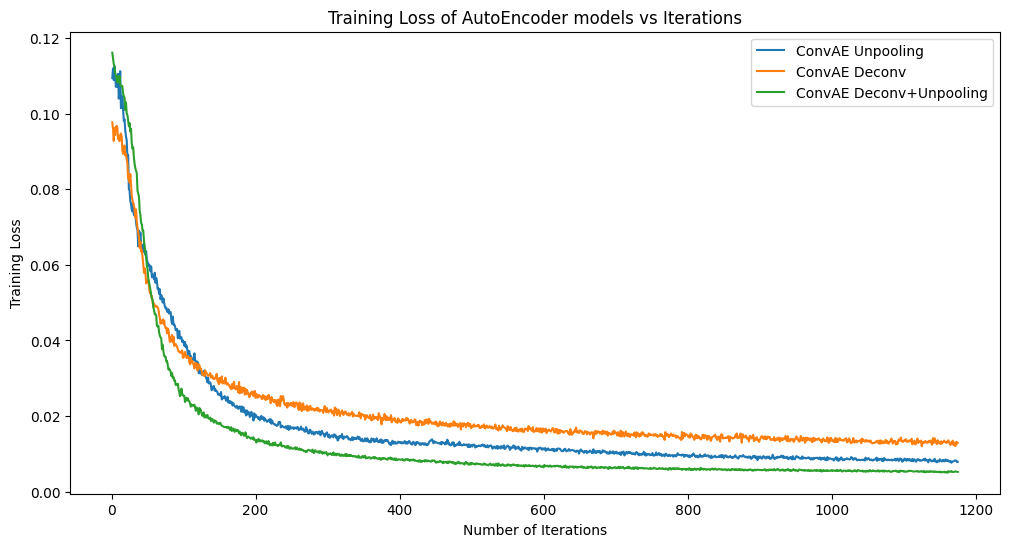

In [60]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1,len(training_loss5a)+1),training_loss5a,label="ConvAE Unpooling")
plt.plot(range(1,len(training_loss5b)+1),training_loss5b,label="ConvAE Deconv")
plt.plot(range(1,len(training_loss5c)+1),training_loss5c,label="ConvAE Deconv+Unpooling")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss of AutoEncoder models vs Iterations")
plt.show()

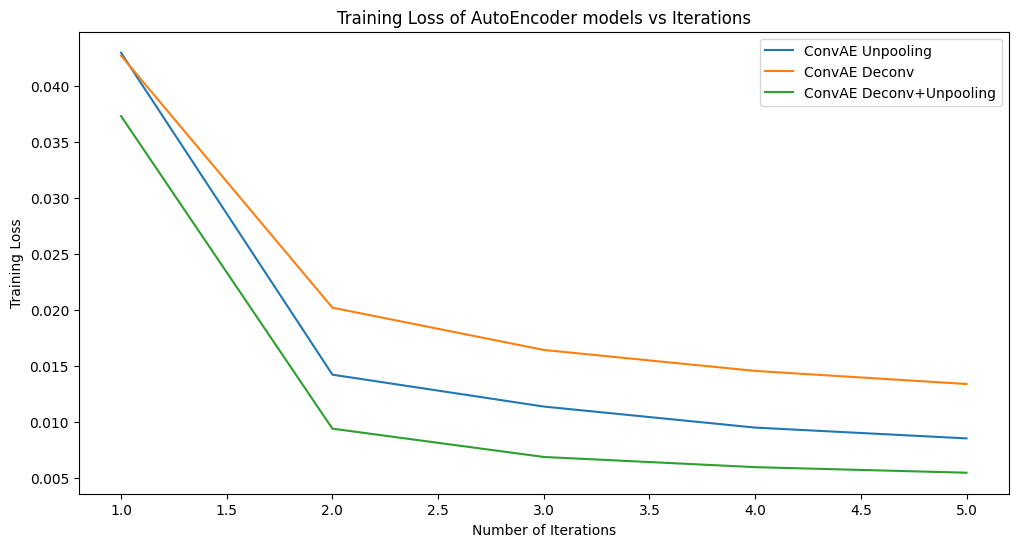

In [61]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1,len(epoch_loss5a)+1),epoch_loss5a,label="ConvAE Unpooling")
plt.plot(range(1,len(epoch_loss5b)+1),epoch_loss5b,label="ConvAE Deconv")
plt.plot(range(1,len(epoch_loss5c)+1),epoch_loss5c,label="ConvAE Deconv+Unpooling")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.title("Training Loss of AutoEncoder models vs Iterations")
plt.show()

The loss functions show an expected result.

The "combined" decoder shows better performances (Unpooling restores the spatial structure of the image by putting back the max value in the original position. Therefore it gives a good starting point to the deconvolution which learns to generate new pixel values based on the feature maps in a learnable way).

Besides, we can see the only-unpooling Net performs better than the only-deconvolution. Makes sense since the former remember the spatial geometry of the image and by putting back the max value in the original place, it probably reduce much more the loss function.

Reconstruction representation.

In [62]:
testset_example = torch.utils.data.DataLoader(dataset=testset.data[9705:9715],shuffle=False,batch_size=10)

model5a.eval()
with torch.no_grad():
  for images in testset_example:
    images=images.reshape(10,1,28,28)
    outputs5a,_ = model5a(images.float())

model5b.eval()
with torch.no_grad():
  for images in testset_example:
    images=images.reshape(10,1,28,28)
    outputs5b,_ = model5b(images.float())

model5c.eval()
with torch.no_grad():
  for images in testset_example:
    images=images.reshape(10,1,28,28)
    outputs5c,_= model5c(images.float())

(-0.5, 27.5, 27.5, -0.5)

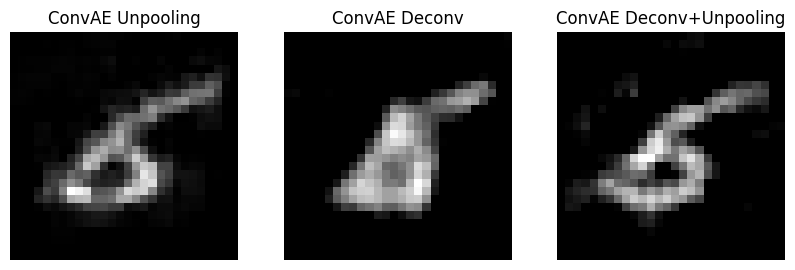

In [63]:
# Then as I did above (comparison between AE and PCA) I plot the digit and the reconstruction error between the three different AEs
plt.rcParams["figure.figsize"] = (10,6)
i = 4

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(outputs5a[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('ConvAE Unpooling')
ax1.axis("off")
ax2.imshow(outputs5b[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('ConvAE Deconv')
ax2.axis("off")
ax3.imshow(outputs5c[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('ConvAE Deconv+Unpooling')
ax3.axis("off")

In [64]:
print("Reconstruction Error in ConvAE Unpooling:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs5a[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs5a[i].detach().numpy()/255)).T)))
print("Reconstruction Error in ConvAE Deconv:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs5b[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs5b[i].detach().numpy()/255)).T)))
print("Reconstruction Error in ConvAE Deconv+Unpooling:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs5c[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs5c[i].detach().numpy()/255)).T)))

Reconstruction Error in ConvAE Unpooling: 21.716841644420125
Reconstruction Error in ConvAE Deconv: 19.325687772502626
Reconstruction Error in ConvAE Deconv+Unpooling: 19.4825306775326


The reconstruction error underlying what said above: the latter Net performs the best!

Also visualize the decoder weights.

In [65]:
print(model5a.encoder_conv1[0].weight.detach().numpy().squeeze().shape)

(8, 3, 3)


In [67]:
#Function for visualisation of weights
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
  n,c,w,h = tensor.shape
  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
  rows = np.min((tensor.shape[0] // nrow + 1, 64))
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure(figsize=(nrow,rows))
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

https://discuss.pytorch.org/t/how-to-visualize-the-actual-convolution-filters-in-cnn/13850

Visualizing decoder weights for convAE with unpooling.

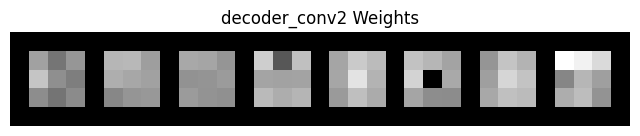

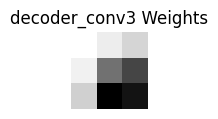

In [68]:
filter = model5a.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()
filter = model5a.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

Visualizing decoder weights for convAE with deconvolution

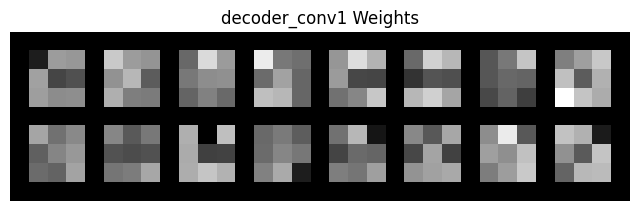

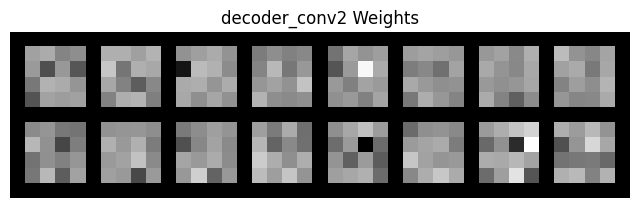

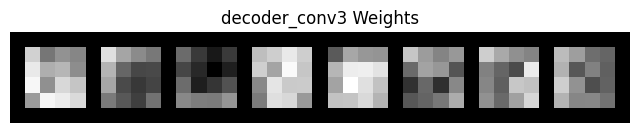

In [69]:
filter = model5b.decoder_conv1[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()
filter = model5b.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()
filter = model5b.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

In the case of deconvolution above we can see some pattern but it's quite difficult to get an idea of what they are actually doing.

Visualizing decoder weights for convAE with deconvolution and unpooling

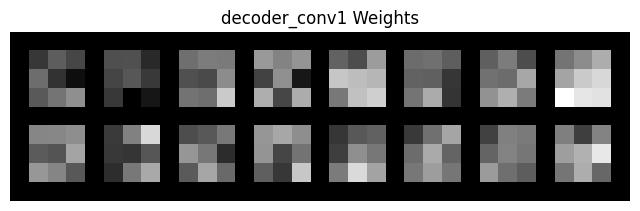

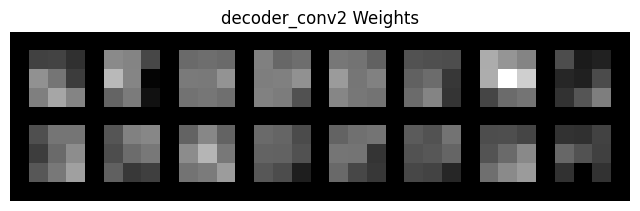

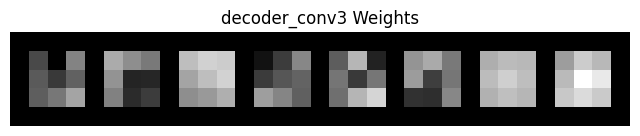

In [70]:
filter = model5c.decoder_conv1[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()
filter = model5c.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()
filter = model5c.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

Here it is difficult as well to spot some patterns. We can observe though that the filters are smaller.

## References
### General
https://www.cse.iitm.ac.in/~miteshk/CS7015_2018.html
### Standard AutoEncoders
https://blog.keras.io/building-autoencoders-in-keras.html
### Denoising AutoEncoders
http://www.opendeep.org/v0.0.5/docs/tutorial-your-first-model </br>
https://medium.com/game-of-bits/denoising-autoencoders-can-reduce-noise-in-images-5b74753eaf97
https://www.youtube.com/watch?v=Qz09h3lLSEk </br>
### Sparse AutoEncoders
https://medium.com/@syoya/what-happens-in-sparse-autencoder-b9a5a69da5c6
### Convolutional AutoEncoders
https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb </br>
https://medium.com/geekculture/deconvolution-and-how-it-works-and-its-importance-80ce8f137e1b